In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# DATA PREPROCESSING
# Load the dataset

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dir = '/content/drive/My Drive/MWD/train'

dataset = tf.keras.utils.image_dataset_from_directory(      dir,
                                                            shuffle=True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= IMG_SIZE    )

Found 847 files belonging to 4 classes.


In [ ]:
class_names= dataset.class_names
class_names

['cloudy', 'rain', 'shine', 'sunrise']

In [ ]:
!pip install tensorflow keras

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        dir,
        target_size=(160, 160),
        batch_size=32,
        shuffle=True,

       class_mode="categorical")

class_indices = train_generator.class_indices

Found 847 images belonging to 4 classes.


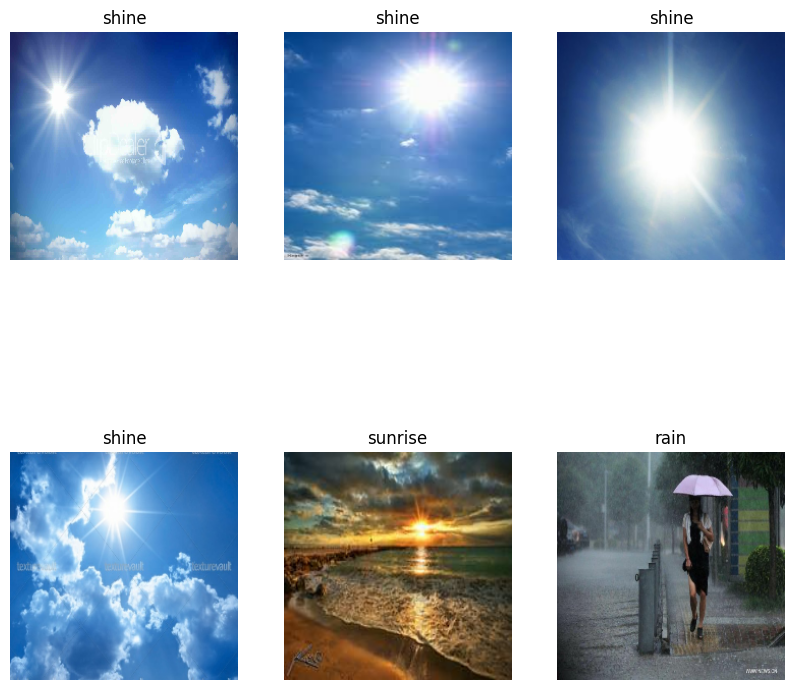

In [ ]:
class_names = dataset.class_names


plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, test_split=0.5, val_split=0.5, shuffle=True, shuffle_size=10000):
    assert (test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    test_size = int(test_split * ds_size)
    val_size = int(val_split * ds_size)

    val_ds = ds.take(val_size)
    test_ds = ds.skip(val_size).take(test_size)


    return val_ds, test_ds

In [ ]:
# Splitthing the dataset into train, validation and test sets.
# Calling the function get_dataset_partitions_pd

dir_train = '/content/drive/My Drive/MWD/train'
dir_test =  '/content/drive/My Drive/MWD/test'
dir_val = '/content/drive/My Drive/MWD/test'


train_dataset = tf.keras.utils.image_dataset_from_directory( dir_train,
                                                            shuffle=True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= IMG_SIZE    )

test_dataset = tf.keras.utils.image_dataset_from_directory( dir_test,
                                                            shuffle=True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= IMG_SIZE    )

validation_dataset, test_dataset = get_dataset_partitions_tf( test_dataset, ds_size=len(test_dataset))


'''
validation_dataset = tf.keras.utils.image_dataset_from_directory( dir_val,
                                                            shuffle=True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= IMG_SIZE    )
test_dataset = tf.keras.utils.image_dataset_from_directory( dir_test,
                                                            shuffle=True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= IMG_SIZE    )'''

Found 847 files belonging to 4 classes.
Found 278 files belonging to 4 classes.


'\nvalidation_dataset = tf.keras.utils.image_dataset_from_directory( dir_val,\n                                                            shuffle=True,\n                                                            batch_size= BATCH_SIZE,\n                                                            image_size= IMG_SIZE    )\ntest_dataset = tf.keras.utils.image_dataset_from_directory( dir_test,\n                                                            shuffle=True,\n                                                            batch_size= BATCH_SIZE,\n                                                            image_size= IMG_SIZE    )'

In [ ]:
# Use buffered prefetching by tensorflow data library to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Dataset Augmentation

# When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity
# by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping.
# This helps expose the model to different aspects of the training data and reduce overfitting.


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

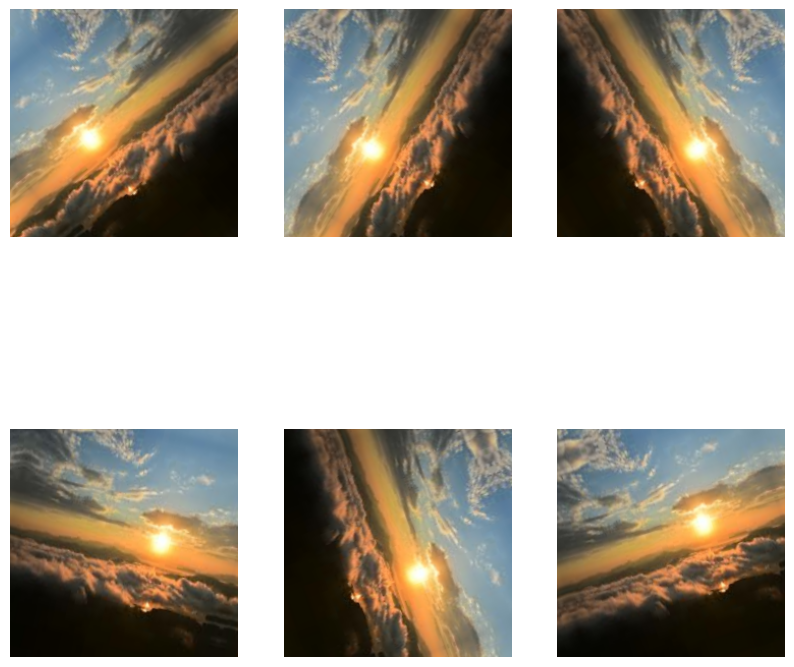

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

rescale = tf.keras.layers.Rescaling(1./255, offset=0.0)

# Download the densenet preprocessing tool

preprocess_input = tf.keras.applications.densenet.preprocess_input

In [ ]:
# CREATE THE BASE MODEL FROM PRETRAINED NETWORKS

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# This feature extractor converts each 224x224x3 image into a 7x7x1024 block of features.
# We can see what it does to an example batch of images as follows,

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 2, 0, 1, 3, 3, 3, 0, 3, 3, 2, 1, 2, 2, 1, 2, 3, 2, 3, 1, 1, 1,
       0, 1, 3, 3, 3, 0, 0, 3, 1, 0], dtype=int32)>

In [ ]:
# Feature Extraction Approach

# Now we will freeze the convolutional base created from the previous step
# and use as a feature extractor. Additionally, we will add a classifier on top
# of it and train the top-level classifier.

# Freezing the convolutional base

# Now we will freeze the convolutional base before we compile and train the model.
# Freezing prevents the weights in a given layer from being updated during training.
# Setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [ ]:
# Add a classification head

# In order to generate predictions from the block of features, average over the
# spatial 5 x 5 spatial locations, using tf.keras.layers.GlobalAveragePooling2D
# layer to convert the features to a single vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
# Now we'll convert these features into a single prediction per image.
# We don't need an activation function here because this prediction
# will be treated as a logit, or a raw prediction value.

prediction_layer = tf.keras.layers.Dense(4,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
#Build a model by chaining together the data augmentation, rescaling, base_model and
#feature extractor layers using the Keras Functional API. As previously mentioned,
#use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#COMPILE THE MODEL

#Compile the model before training it, since there are three classes we'll use SparseCategoricalCrossEntropy.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

In [ ]:
# TRAIN THE MODEL

initial_epochs = 4

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 59s 5s/step - loss: 1.8271 - accuracy: 0.2458


In [ ]:
print("initial loss:", loss0)
print("initial accuracy:",accuracy0)

initial loss: 1.8271111249923706
initial accuracy: 0.24576270580291748


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('weather')

checkpoint = ModelCheckpoint(weight_path,
                             save_best_only=True, save_weights_only = True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callbacks_list = [checkpoint, early]

history = model.fit(train_dataset,epochs=initial_epochs,validation_data=validation_dataset, callbacks = callbacks_list)

Epoch 1/4
27/27 [==============================] - 209s 7s/step - loss: 1.6796 - accuracy: 0.2952 - val_loss: 1.5289 - val_accuracy: 0.2969
Epoch 2/4
27/27 [==============================] - 181s 7s/step - loss: 1.4230 - accuracy: 0.3707 - val_loss: 1.4166 - val_accuracy: 0.3814
Epoch 3/4
27/27 [==============================] - 200s 7s/step - loss: 1.3159 - accuracy: 0.4061 - val_loss: 1.3238 - val_accuracy: 0.4153
Epoch 4/4
27/27 [==============================] - 199s 7s/step - loss: 1.2043 - accuracy: 0.4734 - val_loss: 1.2199 - val_accuracy: 0.4531


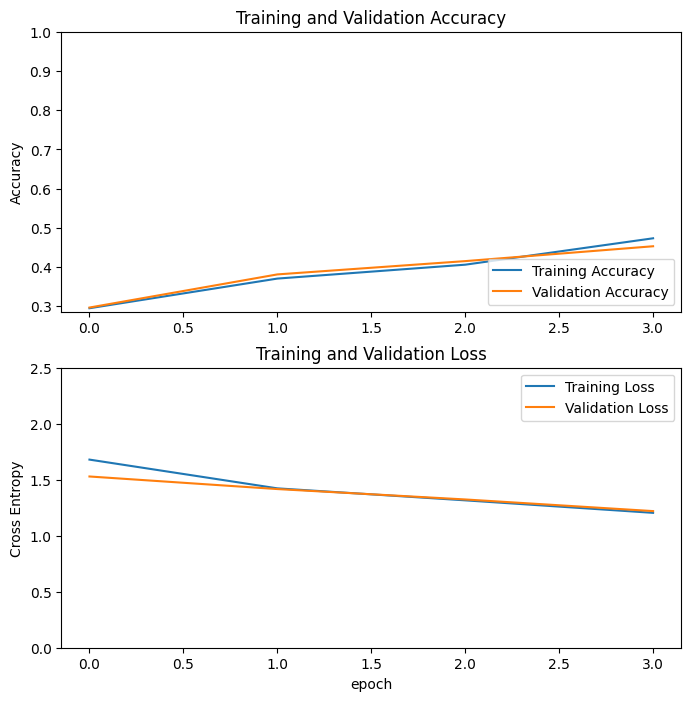

In [ ]:
accrcy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accrcy, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning**

In [ ]:
# Fine Tuning Approach
# In the feature extraction experiment, you were only training a few layers on top of an
# MobileNetV2 base model. The weights of the pre-trained network were not updated during training.


# One way to increase performance even further is to train (or "fine-tune") the weights of the
# top layers of the pre-trained model alongside the training of the classifier you added.
# The training process will force the weights to be tuned from generic feature maps to
# features associated specifically with the dataset.

# Unfreeze the top layers of the model

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  427


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                             

In [ ]:
len(model.trainable_variables)

281

In [ ]:
#Continue training the model

fine_tune_epochs = 4
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 4/8
27/27 [==============================] - 347s 12s/step - loss: 0.6222 - accuracy: 0.7662 - val_loss: 0.2964 - val_accuracy: 0.9322
Epoch 5/8
27/27 [==============================] - 313s 11s/step - loss: 0.2604 - accuracy: 0.9079 - val_loss: 0.1305 - val_accuracy: 0.9688
Epoch 6/8
27/27 [==============================] - 334s 12s/step - loss: 0.1872 - accuracy: 0.9374 - val_loss: 0.1323 - val_accuracy: 0.9766
Epoch 7/8
27/27 [==============================] - 309s 11s/step - loss: 0.1457 - accuracy: 0.9516 - val_loss: 0.1187 - val_accuracy: 0.9609
Epoch 8/8
27/27 [==============================] - 308s 11s/step - loss: 0.1220 - accuracy: 0.9599 - val_loss: 0.0564 - val_accuracy: 0.9746


In [ ]:
accrcy += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

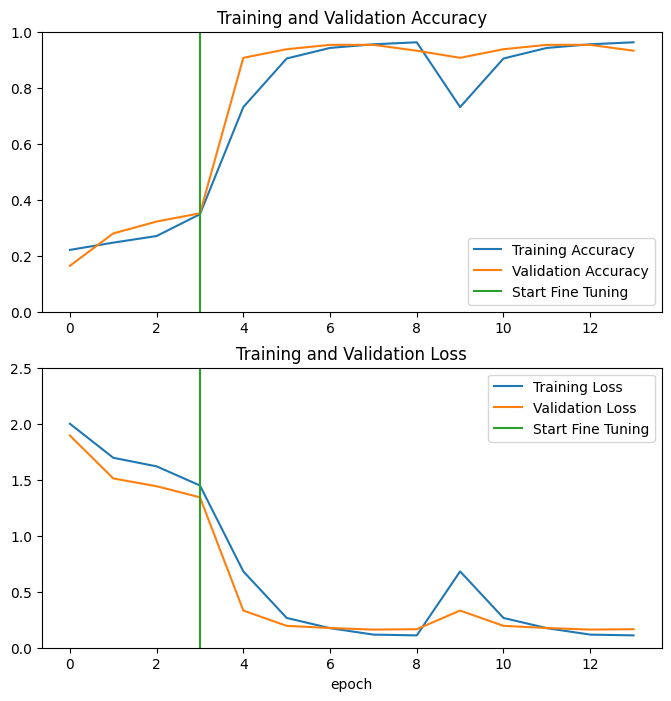

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.0, 2.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluation and Prediction

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 22s 5s/step - loss: 0.1403 - accuracy: 0.9576
Test accuracy : 0.9576271176338196


Predictions:
 [1 0 1 2 2 1 1 3 0 0 1 1 3 2 3 0 3 0 0 1 2 3 3 2 3 0 2 0 0 2 3 1]
Labels:
 [1 0 1 2 2 1 1 3 0 0 1 1 3 2 3 0 3 0 0 1 2 1 3 2 3 0 2 0 0 2 3 1]


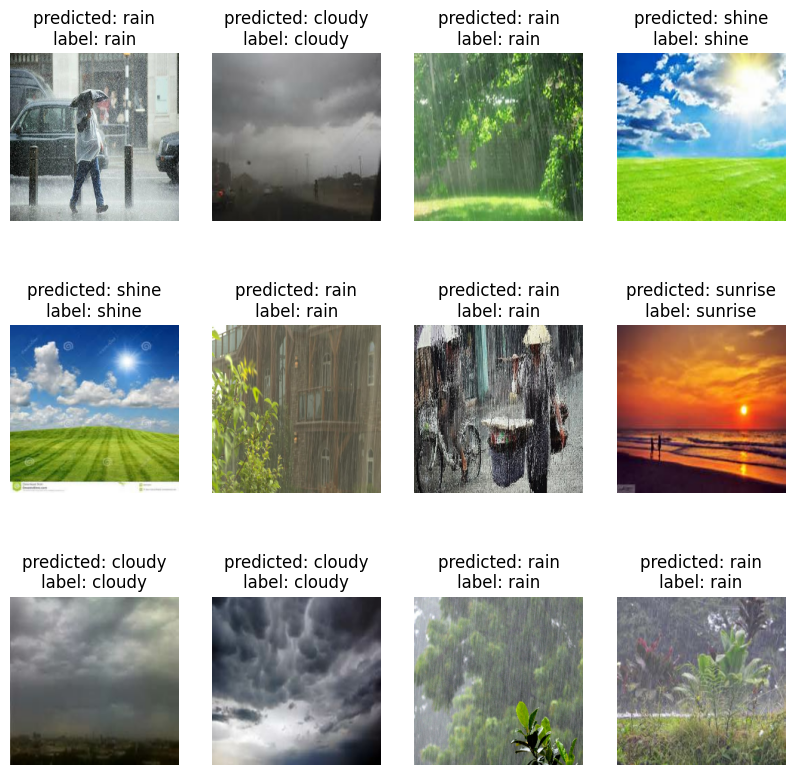

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
y_true=label_batch
# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)
y_pred_proba=np.amax(predictions,1)
predictions = np.argmax(predictions, 1)
y_pred=predictions
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('predicted: ' + class_names[predictions[i]]+'\n'+ 'label: ' +class_names[label_batch[i]])
  plt.axis("off")

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('int') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.

    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

In [ ]:
from sklearn.metrics import precision_score , recall_score
import sklearn.metrics as metrics
from sklearn.metrics import classification_report


def calculate_metrics1(y_true,y_pred):
    print(classification_report(y_true, y_pred))

calculate_metrics1(y_true,y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93         7

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



In [ ]:
model.save('/content/drive/My Drive/Computer_Vision_Code/cvmodel.keras')

In [ ]:
#new_model = tf.keras.models.load_model('cvmodel.keras')

# Show the model architecture
#new_model.summary()


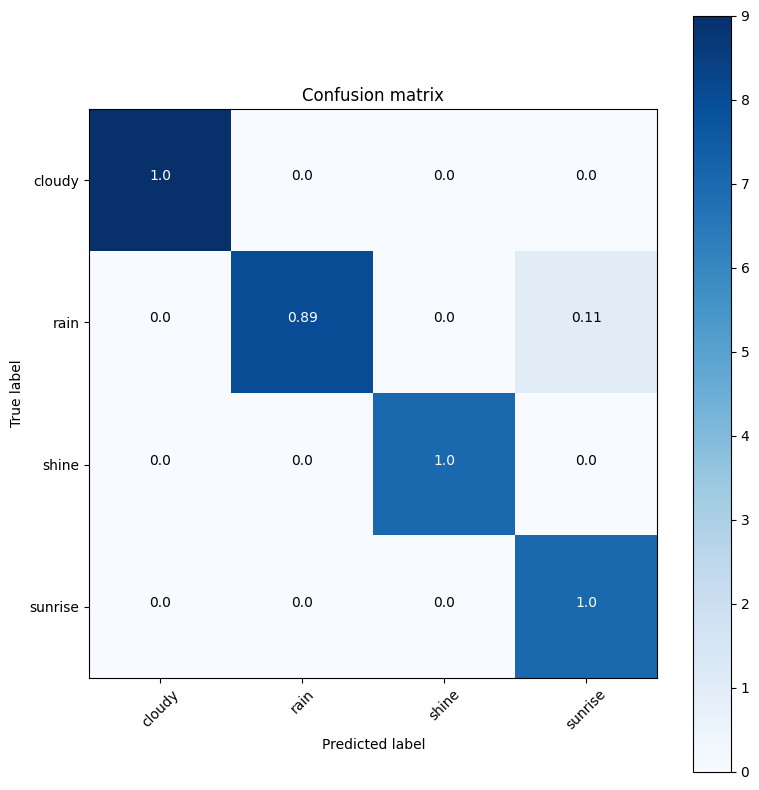

In [ ]:
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

confusion_matrix

plot_confusion_matrix(confusion_matrix, class_names)